In [17]:
import sys
import os
import torch
import transformers
import json
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
from src.model.minigpt4 import MiniGPT4
from tqdm import *
import random
from generation import *
import json
device = "cuda:4" if torch.cuda.is_available() else "cpu"
model = MiniGPT4(lora_r=64)
model = model.to(device)
model.load_state_dict(torch.load("/data1/poong/PosterNUWA/log_dir/train_stage2/checkpoints/checkpoint-1/pytorch_model.bin",map_location="cpu"))
model.device = device
#model.half()
model.eval()
def evaluate(
    image,
    html_input,
    temperature=0.6,
    top_p=0.9,
    top_k=40,
    num_beams=4,
    do_sample=True,
    max_new_tokens=1024,
    **kwargs,
):

    # import pdb; pdb.set_trace()
    with torch.no_grad():
        with torch.autocast(device_type="cuda"):
            generation_output = model.generate(image,html_input,max_new_tokens=max_new_tokens)
    return generation_output

file_path = "/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/html_format_test/test_numerical.jsonl"
with open(file_path, "r") as f:
    content = [json.loads(line) for line in f]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/data1/poong/.conda/envs/jaepoong/lib/python3.9/site-packages/peft/utils/other.py:136: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035
Do not use Q-Former here.
Load 1 training prompts
Prompt Example 
['[INST] <Img><ImageHere></Img> [/INST] ']


In [74]:
from PIL import Image
from src.processor.blip_processors import Blip2ImageTrainProcessor
from html_to_ui import *
image_processor = Blip2ImageTrainProcessor()
def split_string_by_delimiter(input_string, delimiter):
    # 입력 문자열을 특정 문자(delimiter)를 기준으로 분할하여 전후 문자열을 반환합니다.
    parts = input_string.split(delimiter)

    # 분할된 문자열이 두 개 이상인 경우, 전후 문자열을 반환합니다.
    if len(parts) >= 2:
        before_delimiter = parts[0]
        after_delimiter = delimiter.join(parts[1:])
        return before_delimiter, after_delimiter
    else:
        # 특정 문자(delimiter)를 찾을 수 없는 경우, 원래 문자열과 빈 문자열을 반환합니다.
        return input_string, ""

img_path = "/data1/poong/PosterNUWA/data/cgl_dataset/layout_imgs_6w"
sample = content[10]
image = Image.open(os.path.join("data/cgl_dataset/box_inpainintg_layout_cgl",sample['name'][0][:-4]+"_mask000.png"))
image2 = image.copy()
img = image_processor(image).unsqueeze(0)
cond_recover_mask_input = sample.get("cond_recover_mask_input_seqs")
instruct_3,answer_3 = split_string_by_delimiter(cond_recover_mask_input[0],"<MID>")
cond_recover_mask = evaluate(img,[instruct_3])
cond_recover_mask

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['<body> <svg width="513" height="750"> <rect data-category="logo", x="146", y="26", width="222", height="42"/>\n<rect data-category="text", x="106", y="91", width="302", height="36"/>\n<rect data-category="text", x="113", y="138", width="288", height="41"/>\n<rect data-category="background", x="123", y="192", width="267", height="45"/>\n<rect data-category="text", x="140", y="200", width="235", height="23"/>\n<rect data-category="text", x="12", y="670", width="128", height="23"/> </svg> </body>']

<body> <svg width="513" height="750"> <rect data-category="logo", x="146", y="26", width="222", height="42"/>
<rect data-category="text", x="106", y="91", width="302", height="36"/>
<rect data-category="text", x="113", y="138", width="288", height="41"/>
<rect data-category="background", x="123", y="192", width="267", height="45"/>
<rect data-category="text", x="140", y="200", width="235", height="23"/>
<rect data-category="text", x="12", y="670", width="128", height="23"/> </svg> </body>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=513x750 at 0x7F80ED699880>
b, l :  [146, 26, 222, 42] 1
b, l :  [106, 91, 302, 36] 2
b, l :  [113, 138, 288, 41] 2
b, l :  [123, 192, 267, 45] 3
b, l :  [140, 200, 235, 23] 2
b, l :  [12, 670, 128, 23] 2


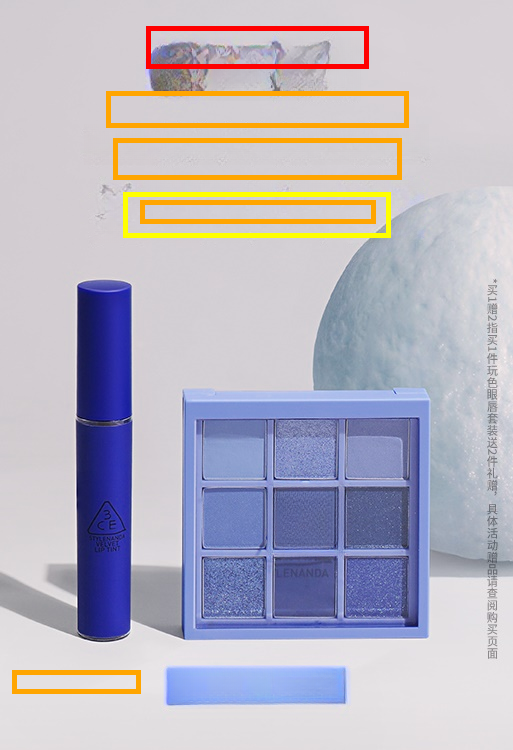

In [76]:
print(cond_recover_mask[0])
ex_bbox,ex_labels = get_bbox(cond_recover_mask[0])
draw_bbox(image,ex_bbox,ex_labels)


<PIL.Image.Image image mode=RGB size=513x750 at 0x7F80EC615FA0>
b, l :  [146, 37, 215, 64] 1
b, l :  [84, 124, 345, 41] 2
b, l :  [90, 178, 333, 65] 2
b, l :  [267, 482, 83, 78] 1
b, l :  [165, 666, 185, 43] 3
b, l :  [187, 677, 151, 23] 2


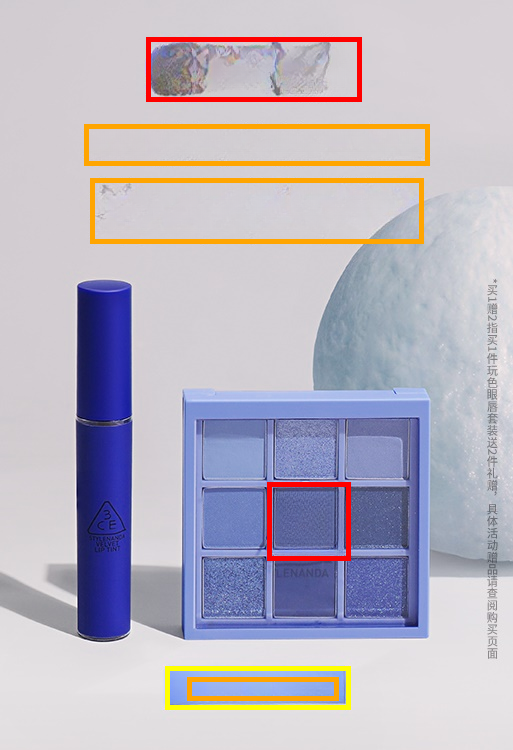

In [77]:
print(answer_3.strip())
ex_bbox,ex_labels = get_bbox(sample['labels'][0])
draw_bbox(image2,ex_bbox,ex_labels)

In [66]:
import json
file_path = "/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/html_format_test/test_numerical.jsonl"
with open(file_path, "r") as f:
    content = [json.loads(line) for line in f]

from PIL import Image
from src.processor.blip_processors import Blip2ImageTrainProcessor
from html_to_ui import *
image_processor = Blip2ImageTrainProcessor()
def split_string_by_delimiter(input_string, delimiter):
    # 입력 문자열을 특정 문자(delimiter)를 기준으로 분할하여 전후 문자열을 반환합니다.
    parts = input_string.split(delimiter)

    # 분할된 문자열이 두 개 이상인 경우, 전후 문자열을 반환합니다.
    if len(parts) >= 2:
        before_delimiter = parts[0]
        after_delimiter = delimiter.join(parts[1:])
        return before_delimiter, after_delimiter
    else:
        # 특정 문자(delimiter)를 찾을 수 없는 경우, 원래 문자열과 빈 문자열을 반환합니다.
        return input_string, ""

img_path = "/data1/poong/PosterNUWA/data/cgl_dataset/layout_imgs_6w"
samples = content[17]
image = Image.open(os.path.join("data/cgl_dataset/box_inpainintg_layout_cgl",samples['name'][0][:-4]+"_mask000.png"))
image2 = image.copy()
img = image_processor(image)
img_l = torch.stack([img]*3)

cond_cate_to_size_pos = samples.get("cond_cate_size_to_pos_input_seqs")
cond_cate_size_to_pos = samples.get("cond_cate_to_size_pos_input_seqs")
cond_recover_mask_input = samples.get("cond_recover_mask_input_seqs")
labels = samples.get("labels")
instruct = []
instruct_1,answer_3 = split_string_by_delimiter(cond_cate_to_size_pos[0],"<MID>")
instruct.append(instruct_1)
instruct_2,answer_3 = split_string_by_delimiter(cond_cate_size_to_pos[0],"<MID>")
instruct.append(instruct_2)
instruct_3,answer_3 = split_string_by_delimiter(cond_recover_mask_input[0],"<MID>")
instruct.append(instruct_3)

#instruct_3,answer_3 = split_string_by_delimiter(cond_recover_mask_input[0],"<MID>")
#cond_recover_mask = evaluate(img_l,instruct)
#cond_recover_mask


<PIL.Image.Image image mode=RGB size=513x750 at 0x7FC9D1938D60>
b, l :  [101, 28, 312, 44] 1
b, l :  [74, 107, 363, 45] 2
b, l :  [122, 159, 273, 40] 2
b, l :  [83, 459, 43, 41] 3
b, l :  [91, 467, 27, 24] 2


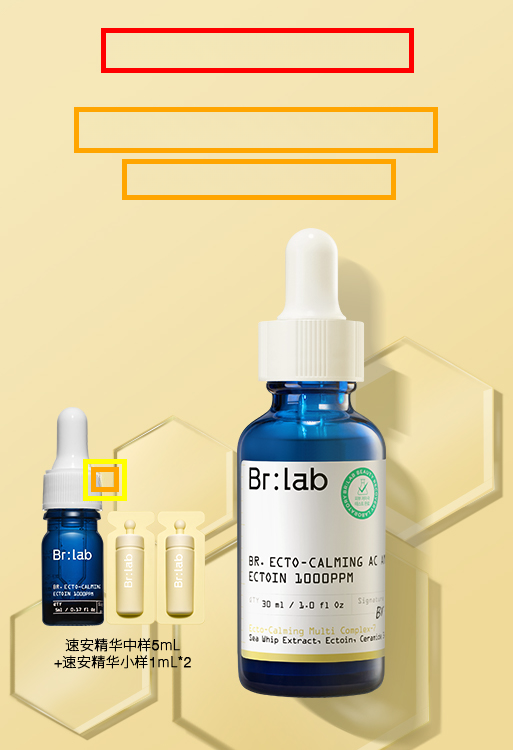

In [67]:
print(answer_3.strip())
image2 = image.copy()
ex_bbox,ex_labels = get_bbox(labels[0])
draw_bbox(image2,ex_bbox,ex_labels)

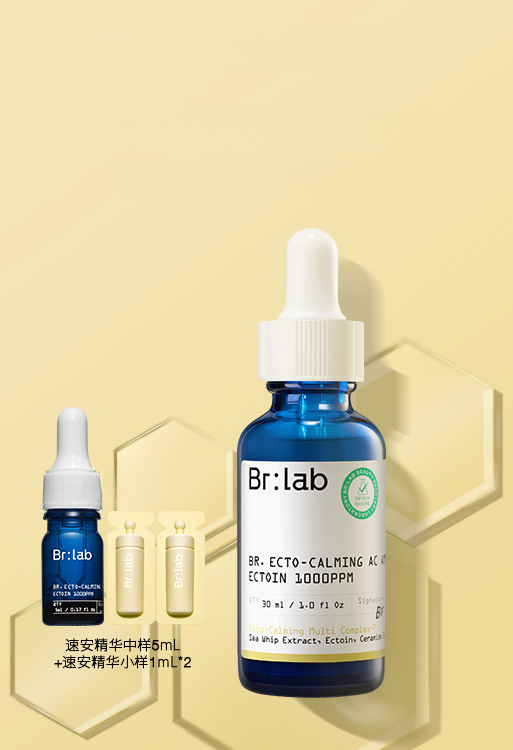

In [68]:
image

In [8]:
file_path="/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/html_format_test/test_numerical.jsonl"
output_dir = "/data1/poong/PosterNUWA/log_dir/test/generated_sample"
output_file = os.path.join(output_dir, file_path.split("/")[-1])
with open(output_file, "w") as f:
    for line in res:
        f.write(json.dumps(line) + "\n")

# ControllNet

In [77]:
# pip install accelerate transformers safetensors diffusers

import torch
import numpy as np
from PIL import Image
import json
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import DPTImageProcessor, DPTForDepthEstimation,DPTFeatureExtractor

import torch
from typing import List
from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore

from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image

from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore
import os
import copy


def concatenate_images(images: List[Image.Image]) -> Image.Image:
    # 이미지 크기 가져오기
    widths, heights = zip(*(img.size for img in images))

    # 총 가로 너비 계산
    total_width = sum(widths)

    # 새로운 이미지 생성
    result_image = Image.new("RGB", (total_width, heights[0]))

    # 이미지 이어붙이기
    x_offset = 0
    for img in images:
        result_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return result_image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Depth estimation
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

# image caption operator
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
)

# controllnet operator
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0-small",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
pipe.enable_model_cpu_offload()
controlnet_conditioning_scale = 0.5
# clip operator
to_tensor = transforms.ToTensor()
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)

# dataset
file_path = "/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train.json"

with open(file_path, "r") as f:
    content = json.load(f)
    
img_path = "data/cgl_dataset/cgl_inpainting_all"

consistency_num = 3
aug_num = 3
aug_save_path = "data/cgl_dataset/augment_cgl"
cont = {}#
cont["categories"] = content["categories"]#
cont["annotations"] = []
cont["images"] = []
os.makedirs(aug_save_path,exist_ok=True)

for i in range(len(content["images"])):
    samples = []
    aug_score = []
    
    orig_image = Image.open(os.path.join("data/cgl_dataset/cgl_inpainting_all",content["images"][i]["file_name"][:-4]+".png"))#
    size = orig_image.size
    orig_image = orig_image.resize((1024,1024))
    # text description of original image
    inputs = blip_processor(images=orig_image, return_tensors="pt").to(device, torch.float16)
    generated_ids = blip_model.generate(**inputs)
    caption_orig = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    prompt = "please generate" + caption_orig + " in advertisement poster design without text"
    # estimate depth
    depth_image = get_depth_map(orig_image)
    

    # controllnet estimation
    generated_image = pipe(
        [prompt]*consistency_num,
        image=orig_image,
        control_image=depth_image,
        strength=0.99,
        num_inference_steps=10,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
    ).images
    
    # resizing
    #generated_image = generated_image.resize(size)
    #depth_image = depth_image.resize(size)
    #orig_image = orig_image.resize(size)
    # text description of generated image
    inputs = blip_processor(images=generated_image, return_tensors="pt").to(device, torch.float16)
    generated_ids = blip_model.generate(**inputs)
    caption_generated = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
    
    #images =  concatenate_images([orig_image,depth_image,generated_image])
    for k in range(len(caption_generated)):
        print("original_caption : " ,caption_orig)
        print("generated_caption : ",caption_generated[k])
        generated_values=metric(to_tensor(generated_image[k]).to(device), caption_orig)
        orig_values=metric(to_tensor(orig_image).to(device), caption_orig)
        print("score of generated_image - caption_orig :",generated_values)
        print("score of orig_image - caption_orig :",orig_values)
        samples.append(generated_image[k])
        aug_score.append(generated_values.item())


    #if i%100==0:
    #    images.save(f"/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/test_sample/augment_sample/{i}.png")
        
    max_indices = sorted(range(len(aug_score)), key=lambda i: aug_score[i], reverse=True)[:aug_num]
    selected_images = [samples[i] for i in max_indices]
    
    cont["annotations"].append(content["annotations"][i])#.append(sample)
    samp = copy.deepcopy(content["images"][i])
    samp["file_name"] = [samp["file_name"]]
    #cont["images"].append(content["images"][i])
    for j,selected_image in enumerate(selected_images):
        selected_save_path = content["images"][i]["file_name"].split(".")[0]+f"_aug{j}."+content["images"][i]["file_name"].split(".")[1]
        selected_image.save(os.path.join(aug_save_path,selected_save_path))
        #cont["annotations"].append(cont["annotations"][i])
        #samp = copy.deepcopy(content["images"][i])
        samp["file_name"].append(selected_save_path)
        #cont["images"].append(samp)
    cont["images"].append(samp)
    break
cont

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

original_caption :  a white suitcase with wheels on a chair
generated_caption :  a suitcase with wheels on a bed

score of generated_image - caption_orig : tensor(22.6629, device='cuda:0', grad_fn=<SqueezeBackward0>)
score of orig_image - caption_orig : tensor(22.7062, device='cuda:0', grad_fn=<SqueezeBackward0>)
original_caption :  a white suitcase with wheels on a chair
generated_caption :  a white suitcase sitting on top of a couch

score of generated_image - caption_orig : tensor(22.5949, device='cuda:0', grad_fn=<SqueezeBackward0>)
score of orig_image - caption_orig : tensor(22.7062, device='cuda:0', grad_fn=<SqueezeBackward0>)
original_caption :  a white suitcase with wheels on a chair
generated_caption :  a white suitcase with wheels on a couch

score of generated_image - caption_orig : tensor(23.0779, device='cuda:0', grad_fn=<SqueezeBackward0>)
score of orig_image - caption_orig : tensor(22.7062, device='cuda:0', grad_fn=<SqueezeBackward0>)


{'categories': [{'supercategory': 'Logo', 'id': 1, 'name': 'Logo'},
  {'supercategory': '文字', 'id': 2, 'name': '文字'},
  {'supercategory': '衬底', 'id': 3, 'name': '衬底'},
  {'supercategory': '符号元素', 'id': 4, 'name': '符号元素'},
  {'supercategory': '强调突出子部分文字', 'id': 5, 'name': '强调突出子部分文字'}],
 'annotations': [[{'area': 19719,
    'bbox': [101, 674, 313, 63],
    'category_id': 2,
    'image_id': 2}]],
 'images': [{'file_name': ['O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw.jpg',
    'O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw_aug0.jpg',
    'O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw_aug1.jpg',
    'O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw_aug2.jpg'],
   'url': 'O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw.jpg',
   'height': 750,
   'width': 513,
   'id': 2}]}

# PKU

In [1]:
# pip install accelerate transformers safetensors diffusers

import torch
import numpy as np
from PIL import Image
import json
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import DPTImageProcessor, DPTForDepthEstimation,DPTFeatureExtractor

import torch
from typing import List
from torchvision import transforms

from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image

from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore
from dreamsim import dreamsim
import os
import copy


def concatenate_images(images: List[Image.Image]) -> Image.Image:
    # 이미지 크기 가져오기
    widths, heights = zip(*(img.size for img in images))

    # 총 가로 너비 계산
    total_width = sum(widths)

    # 새로운 이미지 생성
    result_image = Image.new("RGB", (total_width, heights[0]))

    # 이미지 이어붙이기
    x_offset = 0
    for img in images:
        result_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return result_image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Depth estimation
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

# image caption operator
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 2}, torch_dtype=torch.float16
)

# controllnet operator
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0-small",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()
controlnet_conditioning_scale = 0.5
# clip operator
to_tensor = transforms.ToTensor()
#metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)
model, preprocess = dreamsim(pretrained=True,cache_dir=".cache") 
    
img_path = "data/PKU_PosterLayout/train/inpainted_poster"
img_paths = os.listdir(img_path)

consistency_num = 10
aug_num = 3
aug_save_path = "data/PKU_PosterLayout/train/pku_aug"
cont = {}#
os.makedirs(aug_save_path,exist_ok=True)

for i in range(len(img_paths)):
    samples = []
    aug_score = []
    
    orig_image = Image.open(os.path.join(img_path,img_paths[i]))#
    size = orig_image.size
    orig_image = orig_image.resize((1024,1024))
    # text description of original image
    inputs = blip_processor(images=orig_image, return_tensors="pt").to(device, torch.float16)
    generated_ids = blip_model.generate(**inputs)
    caption_orig = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    prompt = "please generate" + caption_orig + " in advertisement poster design without text"
    # estimate depth
    depth_image = get_depth_map(orig_image)
    

    # controllnet estimation
    generated_image = pipe(
        [prompt]*consistency_num,
        image=orig_image,
        control_image=depth_image,
        strength=0.99,
        num_inference_steps=10,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
    ).images
    
    img1 = preprocess(orig_image)
    for k in range(len(generated_image)):
        img2 = preprocess(generated_image[k])
        distance = model(img1,img2)
        print(distance)
        samples.append(img2)
        aug_score.append(distance)
    break
    max_indices = sorted(range(len(aug_score)), key=lambda i: aug_score[i], reverse=True)[:aug_num]
    selected_images = [samples[i] for i in max_indices]
    for j,selected_image in enumerate(selected_images):
        selected_save_path = img_path[i].split(".")[0]+f"_aug{j}."+img_path[i].split(".")[1]
        selected_image.save(os.path.join(aug_save_path, selected_save_path))

/workspace/poong/anaconda3/lib/python3.11/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Keyword arguments {'device': 'cuda:2'} are not expected by StableDiffusionXLControlNetImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Using cached .cache


Using cache found in .cache/facebookresearch_dino_main
/workspace/poong/anaconda3/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/workspace/poong/anaconda3/lib/python3.11/site-packages/peft/tuners/lora.py:143: UserWarning: fan_in_fan_out is set to True but the target module is not a Conv1D. Setting fan_in_fan_out to False.
  warnings.warn(
/workspace/poong/anaconda3/lib/python3.11/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
import torch
import numpy as np
from PIL import Image
import json
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import DPTImageProcessor, DPTForDepthEstimation,DPTFeatureExtractor

import torch
from typing import List
from torchvision import transforms

from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image

from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore
from dreamsim import dreamsim
import os
import copy

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

device = "cuda" if torch.cuda.is_available() else "cpu"
img_path = "data/PKU_PosterLayout/train/inpainted_poster"

# Depth estimation
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

orig_image = Image.open(os.path.join(img_path,'O1CN011h2Oqe1iNFNjZjeB4_!!2200676434400-0-alimamazszw.png'))#
size = orig_image.size
orig_image = orig_image.resize((1024,1024))
depth_image = get_depth_map(orig_image)
depth_image




# ood example 뽑기

In [1163]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image
from transformers import DPTImageProcessor, DPTForDepthEstimation,DPTFeatureExtractor
from transformers import Blip2Processor, Blip2ForConditionalGeneration

from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore
#from dreamsim import dreamsim
import os
from PIL import Image
import copy
import numpy as np
import torch
import json
def concatenate_images(images) -> Image.Image:
    # 이미지 크기 가져오기
    widths, heights = zip(*(img.size for img in images))

    # 총 가로 너비 계산
    total_width = sum(widths)

    # 새로운 이미지 생성
    result_image = Image.new("RGB", (total_width, heights[0]))

    # 이미지 이어붙이기
    x_offset = 0
    for img in images:
        result_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return result_image
file_path = "data/cgl_dataset/for_posternuwa/raw/train.json"

with open(file_path, "r") as f:
    content = json.load(f)
    
img_path = "data/cgl_dataset/cgl_inpainting_all"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Depth estimation
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

# image caption operator
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
)

# controllnet operator
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0-small",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()
controlnet_conditioning_scale = 0.5
# clip operator
to_tensor = transforms.ToTensor()
#metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)
#model, preprocess = dreamsim(pretrained=True,cache_dir=".cache") 
    
img_path = "/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/cgl_inpainting_all"
img_paths = os.listdir(img_path)

consistency_num = 10
aug_num = 3
aug_save_path = "data/PKU_PosterLayout/train/pku_aug"
cont = {}#
os.makedirs(aug_save_path,exist_ok=True)

samples = []
aug_score = []

orig_image = Image.open(os.path.join(img_path,'O1CN010FPWFB2NCA2PqPl8M_!!2208502009926-0-alimamazszw.png'))#'O1CN011h2Oqe1iNFNjZjeB4_!!2200676434400-0-alimamazszw.png'))#'O1CN0101jDHL1xHUen52Xff_!!2999166418-0-alimamazszw.jpg'

size = orig_image.size
orig_image = orig_image.resize((1024,1024))
# text description of original image
inputs = blip_processor(images=orig_image, return_tensors="pt").to(device, torch.float16)
generated_ids = blip_model.generate(**inputs)
caption_orig = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
prompt = "please generate " + caption_orig +"in colorful advertisement poster design without text"
# estimate depth
depth_image = get_depth_map(orig_image)

# controllnet estimation
generated_image = pipe(
    [prompt]*consistency_num,
    image=orig_image,
    control_image=depth_image,
    strength=0.99,
    num_inference_steps=10,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
).images

#img1 = preprocess(orig_image)
#for k in range(len(generated_image)):
#    img2 = preprocess(generated_image[k])
#    distance = model(img1,img2)
#    print(distance)
#    samples.append(img2)
#    aug_score.append(distance)
#break
#max_indices = sorted(range(len(aug_score)), key=lambda i: aug_score[i], reverse=True)[:aug_num]
#selected_images = [samples[i] for i in max_indices]
#for j,selected_image in enumerate(selected_images):
#    selected_save_path = img_path[i].split(".")[0]+f"_aug{j}."+img_path[i].split(".")[1]
#    selected_image.save(os.path.join(aug_save_path, selected_save_path))
    

/data1/poong/.conda/envs/jaepoong/lib/python3.9/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/data1/poong/.conda/envs/jaepoong/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

a modern office with a large desk and two computers


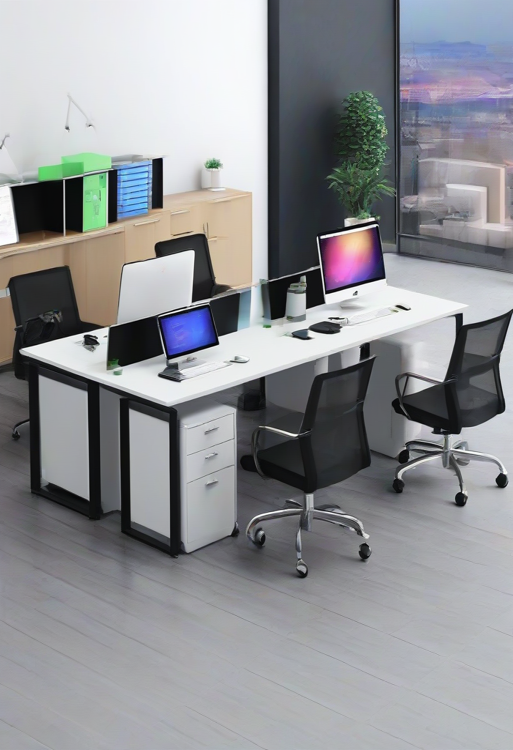

In [1180]:
#display(orig_image.resize([513,750]))
#display(depth_image.resize([513,750]))
print(caption_orig)
#ind = 0
ind -= 1
generated_image[ind].resize([513,750])

# make_json_file_for raw/train.json

In [60]:
import json

train_json_path = "/data1/poong/PosterNUWA/data/cgl_dataset/layout_train_6w_fixed_v2.json"
test_json_path = "/data1/poong/PosterNUWA/data/cgl_dataset/layout_test_6w_fixed_v2.json"
with open(train_json_path,"r") as f:
    train_json = json.load(f)

with open(test_json_path , "r") as f:
    test_json = json.load(f)


In [61]:
train_json["annotations"]+=test_json["annotations"]
train_json["images"] +=test_json["images"]

with open("/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train.json","w") as f:
    train_json = json.dump(train_json,f,indent=2)

In [10]:
import torch
import numpy as np
from PIL import Image
import json
import requests


import torch
from typing import List
from torchvision import transforms

from torchvision import transforms

import os
import copy

def concatenate_images(images: List[Image.Image]) -> Image.Image:
    # 이미지 크기 가져오기
    widths, heights = zip(*(img.size for img in images))

    # 총 가로 너비 계산
    total_width = sum(widths)

    # 새로운 이미지 생성
    result_image = Image.new("RGB", (total_width, heights[0]))

    # 이미지 이어붙이기
    x_offset = 0
    for img in images:
        result_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return result_image

img_path = os.listdir("/home/poong/tjfwownd/tjfwownd/PosterNUWA/output/result_gt_plot")

gt_plot_path = "/home/poong/tjfwownd/tjfwownd/PosterNUWA/output/result_gt_plot"
nuwa_plot_path = "/home/poong/tjfwownd/tjfwownd/PosterNUWA/output/result_plot"
poster_layout_plot_path = "/home/poong/tjfwownd/tjfwownd/PosterLayout-CVPR2023/output/result_plot"
save_path = "/home/poong/tjfwownd/tjfwownd/PosterNUWA/output/gt_poster_nuwa_3image"
for path in img_path:
    try:
        gt_image = Image.open(os.path.join(gt_plot_path,path))
        nuwa_image = Image.open(os.path.join(nuwa_plot_path,path))
        poster_layout_image = Image.open(os.path.join(poster_layout_plot_path,path[:-4]+".jpg"))

        image = concatenate_images([gt_image,nuwa_image,poster_layout_image])
        image.save(os.path.join(save_path,path))
    except:
        pass



In [23]:
import json

with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug_step0.json", "r") as f:
    aug0 = json.load(f)
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug_step1.json", "r") as f:
    aug1 = json.load(f)
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug_step2.json", "r") as f:
    aug2 = json.load(f)
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug_step3.json", "r") as f:
    aug3 = json.load(f)
aug0.keys()

dict_keys(['categories', 'annotations', 'images'])

In [59]:
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_orig.json", "r") as f:
    orig = json.load(f)
orig["images"][1]

{'file_name': 'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw.jpg',
 'url': 'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw.jpg',
 'height': 750,
 'width': 513,
 'id': 6}

In [58]:
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train.json", "r") as f:
    aug = json.load(f)
aug["images"][1]

{'file_name': ['O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw.jpg',
  'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw_aug0.jpg',
  'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw_aug1.jpg',
  'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw_aug2.jpg'],
 'url': 'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw.jpg',
 'height': 750,
 'width': 513,
 'id': 6}

In [45]:
len(aug0["annotations"]+aug1["annotations"]+aug2["annotations"]+aug3["annotations"])
res = {}
res["categories"] = aug0["categories"]
res["annotations"] = aug0["annotations"]+aug1["annotations"]+aug2["annotations"]+aug3["annotations"]
res["images"] = aug0["images"]+aug1["images"]+aug2["images"]+aug3["images"]
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug.json", "w") as f:
    json.dump(res,f,indent=2)

In [4]:
import json
with open("data/cgl_dataset/for_posternuwa/html_format_img_instruct_aug/train_llama_numerical.jsonl", "r") as f:
    aug = [json.loads(line) for line in f]
with open("data/cgl_dataset/for_posternuwa/html_format_img_instruct_all/train_llama_numerical.jsonl", "r") as f:
    orig = [json.loads(line) for line in f]

In [22]:
a,b = aug[30000]["name"],orig[30000]["name"]
import random
def process_input(a):
    if isinstance(a, list):
        # 입력이 리스트인 경우 랜덤하게 하나의 요소를 선택
        if len(a) > 0:
            selected_element = random.choice(a)
            return selected_element
        else:
            return None  # 빈 리스트인 경우 None 반환 또는 다른 처리를 추가할 수 있음
    elif isinstance(a, str):
        # 입력이 문자열인 경우 해당 문자열 반환
        return a
    else:
        # 리스트도 아니고 문자열도 아닌 경우 예외 처리 또는 다른 처리 추가
        raise ValueError("Unsupported input type")

process_input(b)

'O1CN01S9Pv1R1ihOpWQYpJu_!!3277594444-0-alimamazszw.jpg'

# 서준이 Test 인덱스 뽑기

In [1]:
import json

with open("/data1/poong/PosterNUWA/data/PKU_PosterLayout/for_posternuwa/html_format_img_instruct_all_mask_and_all_condition/test_numerical.jsonl" , "r") as f:
    content = [json.loads(line) for line in f]
file =  open("test_img_PKU.txt", "w")
for i in range(len(content)):
    name = content[i]['name'][0]
    print(name)
    file.write(name+'\n')
file.close()

7736_mask.png
4462_mask.png
7550_mask.png
7818_mask.png
3757_mask.png
1887_mask.png
3259_mask.png
9767_mask.png
1176_mask.png
1823_mask.png
4056_mask.png
9535_mask.png
2386_mask.png
7555_mask.png
6742_mask.png
2046_mask.png
5058_mask.png
7025_mask.png
69_mask.png
7854_mask.png
5796_mask.png
89_mask.png
5513_mask.png
7589_mask.png
2936_mask.png
3944_mask.png
2601_mask.png
5730_mask.png
6947_mask.png
1515_mask.png
3882_mask.png
8919_mask.png
7030_mask.png
6031_mask.png
9008_mask.png
8789_mask.png
1471_mask.png
7824_mask.png
1514_mask.png
2079_mask.png
6436_mask.png
3154_mask.png
5268_mask.png
6024_mask.png
3374_mask.png
7086_mask.png
8307_mask.png
4001_mask.png
3169_mask.png
5790_mask.png
3334_mask.png
3142_mask.png
9414_mask.png
2648_mask.png
4009_mask.png
4094_mask.png
7512_mask.png
6995_mask.png
248_mask.png
3729_mask.png
6204_mask.png
5315_mask.png
9344_mask.png
7466_mask.png
5035_mask.png
4862_mask.png
2913_mask.png
4583_mask.png
9839_mask.png
5096_mask.png
113_mask.png
6171_mask.pn

In [13]:
#CGL
from convertHTML.cgl import CGLDataset
data = CGLDataset("/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa","train",25)
content = [name[0] for name in data.attr['name']]

file =  open("train_img_CGL.txt", "w")
for i in range(len(content)):
    name = content[i]
    file.write(name+'\n')
file.close()

In [23]:
#PKU
from convertHTML.pku import PKUDataset
data = PKUDataset("/data1/poong/tjfwownd/PosterNUWA/data/PKU_PosterLayout","train",25)
content = [name for name in data.attr['name']]
file =  open("train_img_PKU.txt", "w")
for i in range(len(content)):
    name = content[i]
    file.write(name+'\n')
file.close()

In [24]:
content

['7736_mask.png',
 '4462_mask.png',
 '7550_mask.png',
 '7818_mask.png',
 '3757_mask.png',
 '1887_mask.png',
 '3259_mask.png',
 '9767_mask.png',
 '1176_mask.png',
 '1823_mask.png',
 '4056_mask.png',
 '9535_mask.png',
 '2386_mask.png',
 '7555_mask.png',
 '6742_mask.png',
 '2046_mask.png',
 '5058_mask.png',
 '7025_mask.png',
 '69_mask.png',
 '7854_mask.png',
 '5796_mask.png',
 '89_mask.png',
 '5513_mask.png',
 '7589_mask.png',
 '2936_mask.png',
 '3944_mask.png',
 '2601_mask.png',
 '5730_mask.png',
 '6947_mask.png',
 '1515_mask.png',
 '3882_mask.png',
 '8919_mask.png',
 '7030_mask.png',
 '6031_mask.png',
 '9008_mask.png',
 '8789_mask.png',
 '1471_mask.png',
 '7824_mask.png',
 '1514_mask.png',
 '2079_mask.png',
 '6436_mask.png',
 '3154_mask.png',
 '5268_mask.png',
 '6024_mask.png',
 '3374_mask.png',
 '7086_mask.png',
 '8307_mask.png',
 '4001_mask.png',
 '3169_mask.png',
 '5790_mask.png',
 '3334_mask.png',
 '3142_mask.png',
 '9414_mask.png',
 '2648_mask.png',
 '4009_mask.png',
 '4094_mask.pn

# Aug image 확인

1064
O1CN010FPWFB2NCA2PqPl8M_!!2208502009926-0-alimamazszw.png


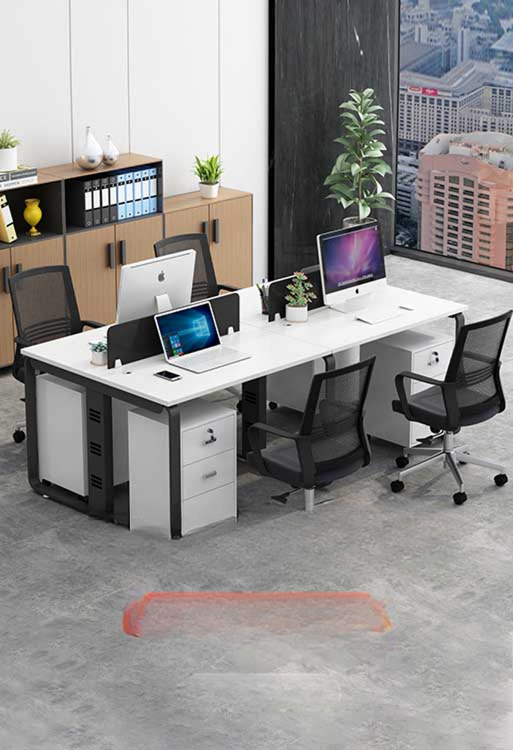

In [1162]:
from PIL import Image
import os
path = "data/cgl_dataset/augment_cgl" # sup index : 136,184
li = sorted(os.listdir(path))
#index =300
#index = 100
#index = 164
index+=1
print(index)
print(li[index])
display(Image.open(os.path.join(path,li[index])))#'O1CN011h2Oqe1iNFNjZjeB4_!!2200676434400-0-alimamazszw.png')))

In [52]:
li[index]

'O1CN0101jDHL1xHUen52Xff_!!2999166418-0-alimamazszw_aug0.jpg'

In [ ]:
import torch
import numpy as np
from PIL import Image
import json
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import DPTImageProcessor, DPTForDepthEstimation,DPTFeatureExtractor

import torch
from typing import List
from torchvision import transforms

from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image

from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore
from dreamsim import dreamsim
import os
import copy

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

device = "cuda" if torch.cuda.is_available() else "cpu"
img_path = "data/PKU_PosterLayout/train/inpainted_poster"

# Depth estimation
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

orig_image = Image.open(os.path.join(img_path,'O1CN011h2Oqe1iNFNjZjeB4_!!2200676434400-0-alimamazszw.png'))#
size = orig_image.size
orig_image = orig_image.resize((1024,1024))
depth_image = get_depth_map(orig_image)
depth_image



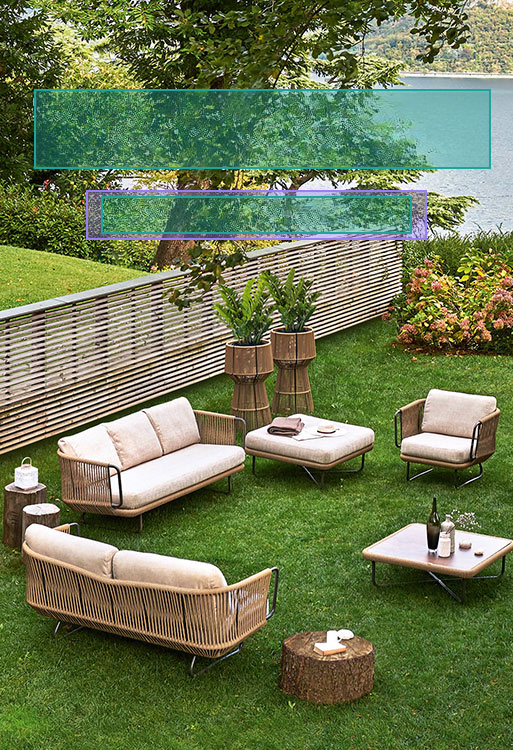

In [1]:
import json
from PIL import Image, ImageDraw
import os
import numpy as np

DATASET_COLOR = {
    1: '#929F29', #"#FF0000",       # 빨 , logo 
    2: '#1FA39A', #"#FFA500",       # 주 , text
    3: '#987FF2', #"#FFFF00",       # 노 , underlay
    4: '#F56881', #"#008000"        # 초 , emblishment
    5: "#0000FF"        # 파
}

box_gt ="log_dir/train_stage2_with_augment_dino_codellama_text/generated_sample/12/box_gt.json"
clses_gt = "log_dir/train_stage2_with_augment_dino_codellama_text/generated_sample/12/clses_gt.json"
text_order = "log_dir/train_stage2_with_augment_dino_codellama_text/generated_sample/12/text_order.json"


with open(box_gt,"r") as f:
    box = json.load(f)
with open(clses_gt,"r") as f:
    cls = json.load(f)

with open(text_order,"r") as f:
    order = json.load(f)

img_dir = "data/cgl_dataset/cgl_inpainting_all"
output_file = f"log_dir/Paper_samples/Real_data"
os.makedirs(os.path.join(output_file,"generated_sample"),exist_ok=True)

save_img= True
for index in range(len(box)):
    boxes = box[index]
    clses = cls[index]
    img_path = order[index]
    
    drawbbox = boxes
    if save_img:
        img = Image.open(os.path.join(img_dir,img_path))
        drawn_outline = img.copy()
        drawn_fill = img.copy()
        draw_ol = ImageDraw.ImageDraw(drawn_outline)
        draw_f = ImageDraw.ImageDraw(drawn_fill)
        
        for b,l in zip(drawbbox,clses):
            draw_ol.rectangle([b[0],b[1],b[2],b[3]], outline=DATASET_COLOR[l], width=2)
        for b,l in zip(drawbbox,clses):
            draw_f.rectangle([b[0],b[1],b[2],b[3]], fill=DATASET_COLOR[l])
        
        drawn_outline = drawn_outline.convert("RGBA")
        drawn_fill = drawn_fill.convert("RGBA")
        drawn_fill.putalpha(int(256 * 0.4))
        img = Image.alpha_composite(drawn_outline, drawn_fill)
        img.save(os.path.join(output_file,img_path.replace("jpg","png")))

display(img)
